In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
from scipy.special import expit

In [2]:

def focal_loss_lgb(y_true, y_pred, alpha=0.25, gamma=2.0):
    a = alpha
    p_t = expit(y_pred)  # Prediction probabilities
    loss = -a * (1 - p_t)**gamma * y_true * np.log(p_t) - \
        (1 - a) * p_t**gamma * (1 - y_true) * np.log(1 - p_t)
    return loss.mean()

# Custom objective for XGBoost (Focal Loss)


def focal_loss_xgb(preds, dtrain, alpha=0.25, gamma=2.0):
    labels = dtrain.get_label()
    preds = expit(preds)
    grad = preds * (1 - preds)
    hess = grad * (1 - grad)

    # Focal loss grad and hess
    grad = alpha * (labels - preds) * (1 - preds)**gamma
    hess = alpha * preds * (1 - preds) * ((1 - preds)**gamma)
    return grad, hess

In [3]:
df = pd.read_csv(
    '/Users/uditrawat/Desktop/CardioX/artifacts/data_ingestion/heart_2020_cleaned.csv')

df.drop(['AgeCategory', 'Race', 'GenHealth'], inplace=True, axis=1)

In [4]:
# Step 1: Preprocess the data (split, encode, etc.)
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

In [ ]:
# Convert target to binary labels
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Label Encoding (if needed)
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

# Step 2: Feature Selection using Chi-Square
chi_selector = SelectKBest(chi2, k=6)
X_train_top6 = chi_selector.fit_transform(X_train, y_train)
X_test_top6 = chi_selector.transform(X_test)

top6_features = X_train.columns[chi_selector.get_support()]
print(f"Top 5 selected features: {list(top6_features)}")

Top 5 selected features: ['Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Diabetic', 'KidneyDisease']


In [6]:
# Step 3: Train XGBoost and LightGBM with tuned `scale_pos_weight`
scale_pos_weight_xgb = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
scale_pos_weight_lgb = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight_xgb, random_state=42)
lgbm_model = LGBMClassifier(
    scale_pos_weight=scale_pos_weight_lgb, random_state=42)

In [8]:
# Fit models
xgb_model.fit(X_train_top6, y_train)
lgbm_model.fit(X_train_top6, y_train)

[LightGBM] [Info] Number of positive: 21898, number of negative: 233938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085594 -> initscore=-2.368661
[LightGBM] [Info] Start training from score -2.368661


LGBMClassifier(random_state=42, scale_pos_weight=10.683076080007307)

In [9]:

# Step 4: Make predictions and ensemble (average of predictions)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_top6)[:, 1]
y_pred_lgbm_proba = lgbm_model.predict_proba(X_test_top6)[:, 1]

In [10]:
# Ensemble: Averaging the probabilities
y_pred_ensemble_proba = (y_pred_xgb_proba + y_pred_lgbm_proba) / 2
y_pred_ensemble = (y_pred_ensemble_proba >= 0.5).astype(int)

In [11]:
# Step 5: Evaluate the ensemble model
print("Classification Report (Ensemble):")
print(classification_report(y_test, y_pred_ensemble))

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     58484
           1       0.20      0.63      0.30      5475

    accuracy                           0.75     63959
   macro avg       0.58      0.69      0.57     63959
weighted avg       0.89      0.75      0.80     63959



In [12]:
# AUC-ROC score for ensemble
roc_auc = roc_auc_score(y_test, y_pred_ensemble_proba)
print(f"AUC-ROC Score (Ensemble): {roc_auc}")

AUC-ROC Score (Ensemble): 0.7370624491138191


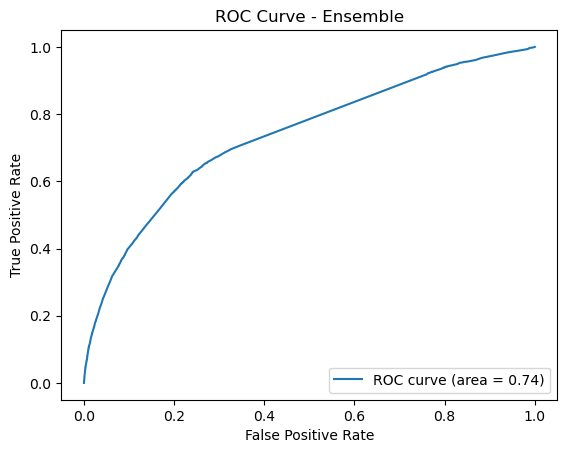

In [13]:
# Plotting ROC Curve for ensemble
fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble')
plt.legend(loc="lower right")
plt.show()



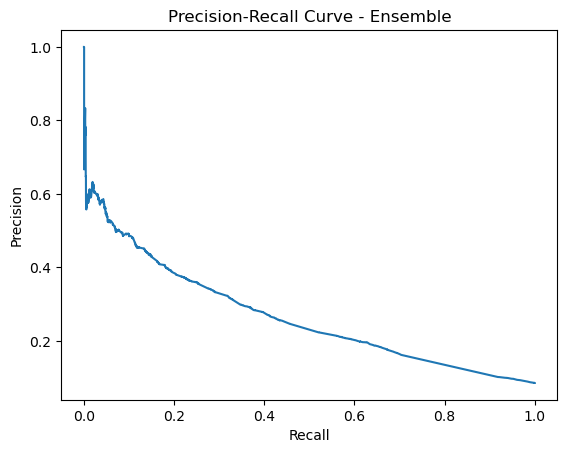

In [14]:
# Precision-Recall Curve for ensemble
precision, recall, _ = precision_recall_curve(y_test, y_pred_ensemble_proba)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble')
plt.show()